#Competition assay analysis and thoughts

Here we will analyze two competition assay conducted as a rough beginning to understand how to best design competition assays to the fluorescent kinase inhibitors (bosutinib, bosutinib isomer, erlotinib, and gefitinib) used in other assays in this repository. 

The **first** (1st) part of this will be looking at data collected trying to compete off bosutinib from Src kinase with imatinib (conducted on March 11, 2015). The **second** (2nd) part of this will be looking at data collected trying to compete off gefitinib from Src kinase with imatinib (conducted on October 30, 2015). The **third** (3rd) part will be some simple modeling to see if these experiments follow our expectations and how we can better design the experiments to get better results from the competition assay. Then in a **fourth** (4th) section we'll work a little on a PYMC model to get affinities from the competition assay.

In [1]:
#import needed libraries
import re
import os
from lxml import etree
import pandas as pd
import pymc
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Couldn't import dot_parser, loading of dot files will not be possible.


## Bosutinib Assay

The first attempt at a Bosutinib-Imatinib competition assay was on March 11, 2015. The full description of the assay can be found [here](https://docs.google.com/document/d/1IGw5RBzevF5hWLiH82LYZjXSnqvF4t-PD7mP0SP46Eo/edit). 
In short (and very similar to as described in the [lab-protocols repository](https://github.com/choderalab/lab-protocols/blob/master/Fluo_Kinase_Inhibitor_Assay/Fluo_Kinase_Inhibitor_Assay.md)) 100 uL of 0.5 $\mu$M Src with a titration of Bosutinib up to 20 $\mu$M in every other row was prepared. In one of two plates 10 $\mu$M Imatinib was added to the whole plate to try to compete off the Bosutinib.

#### importing and plotting data the clunky way for transparency, will change to use platereader.py once it is slightly nicer.

In [2]:
def get_wells_from_section(path):
    reads = path.xpath("*/Well")
    wellIDs = [read.attrib['Pos'] for read in reads]

    data = [(float(s.text), r.attrib['Pos'])
         for r in reads
         for s in r]

    datalist = {
      well : value
      for (value, well) in data
    }
    
    welllist = [
                [
                 datalist[chr(64 + row) + str(col)]          
                 if chr(64 + row) + str(col) in datalist else None
                 for row in range(1,9)
                ]
                for col in range(1,13)
                ]
                
    return welllist

In [3]:
file_BOS= "data/2015-03-11 18-35-16_plate_1.xml"
file_name = os.path.splitext(file_BOS)[0]

In [4]:
root = etree.parse(file_BOS)

In [5]:
Sections = root.xpath("/*/Section")
much = len(Sections)
print "****The xml file " + file_BOS + " has %s data sections:****" % much
for sect in Sections:
    print sect.attrib['Name']

****The xml file data/2015-03-11 18-35-16_plate_1.xml has 7 data sections:****
280_TopRead
280_BottomRead
Abs_280
350_TopRead
350_BottomRead
Abs_350
Abs_480


In [6]:
#Just going to work with topread for now
TopRead = root.xpath("/*/Section")[0]
welllist = get_wells_from_section(TopRead)
Bos_dataframe = pd.DataFrame(welllist, columns = ['A - Src','B - Buffer','C - Src','D - Buffer', 'E - Src','F - Buffer','G - Src','H - Buffer'])

(-0.5, 11.5)

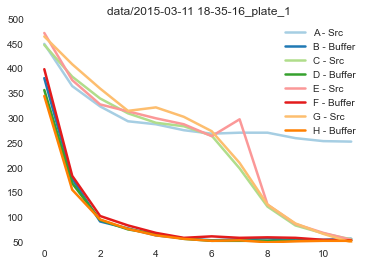

In [7]:
sns.set_palette("Paired", 10)
sns.set_context("notebook", rc={"lines.linewidth": 2.5})

Bos_dataframe.plot(figsize=(6, 4), title=file_name)
plt.xlim(-0.5,11.5)

In [8]:
Bos_dataframe

,A - Src,B - Buffer,C - Src,D - Buffer,E - Src,F - Buffer,G - Src,H - Buffer
0,451,382,449,358,473,400,466,346
1,366,179,385,170,378,185,410,157
2,325,93,341,96,329,104,361,97
3,295,79,311,77,315,85,316,78
4,289,65,292,68,301,70,323,65
5,277,59,285,58,289,60,304,58
6,270,55,266,54,265,63,275,54
7,272,57,200,54,299,60,211,55
8,272,59,123,54,127,61,127,51
9,261,55,85,54,88,60,89,53


In [9]:
file_BOS_IMA= "data/Ima_WIP_SMH_SrcBos_Extend_013015_mdfx_20150311_18.xml"
file_name = os.path.splitext(file_BOS_IMA)[0]
root = etree.parse(file_BOS_IMA)
Sections = root.xpath("/*/Section")
much = len(Sections)
print "****The xml file " + file_BOS_IMA + " has %s data sections:****" % much
for sect in Sections:
    print sect.attrib['Name']

****The xml file data/Ima_WIP_SMH_SrcBos_Extend_013015_mdfx_20150311_18.xml has 7 data sections:****
280_TopRead
280_BottomRead
Abs_280
350_TopRead
350_BottomRead
Abs_350
Abs_480


(-0.5, 11.5)

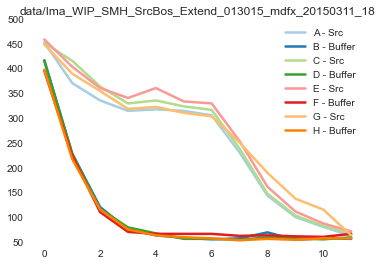

In [10]:
#Just going to work with topread for now
TopRead = root.xpath("/*/Section")[0]
welllist = get_wells_from_section(TopRead)
BosIma_dataframe = pd.DataFrame(welllist, columns = ['A - Src','B - Buffer','C - Src','D - Buffer', 'E - Src','F - Buffer','G - Src','H - Buffer'])
sns.set_palette("Paired", 10)
sns.set_context("notebook", rc={"lines.linewidth": 2.5})

BosIma_dataframe.plot(figsize=(6, 4), title=file_name)
plt.xlim(-0.5,11.5)

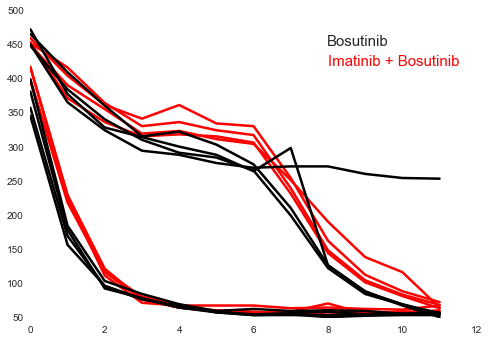

In [11]:
plt.plot(BosIma_dataframe[:].values, 'r');
plt.plot(Bos_dataframe[:].values, 'k');
plt.text(8,450,'Bosutinib',fontsize=15)
plt.text(8,420,'Imatinib + Bosutinib',fontsize=15,color='red')

## Gefitinib Assay

The first attempt at a Gefitinib-Imatinib competition assay was on October 30, 2015. The full description of the assay can be found [here](https://docs.google.com/document/d/1IGw5RBzevF5hWLiH82LYZjXSnqvF4t-PD7mP0SP46Eo/edit). 
In short (and very similar to as described in the [lab-protocols repository](https://github.com/choderalab/lab-protocols/blob/master/Fluo_Kinase_Inhibitor_Assay/Fluo_Kinase_Inhibitor_Assay.md)) 100 uL of 0.5 $\mu$M Src with a titration of Gefitinib up to 20 $\mu$M in every other row was prepared. In one of two plates 10 $\mu$M Imatinib was added to the whole plate to try to compete off the Gefitinib. Note the documentation here could be better, which could be why this data doesn't look particularly great. 

In [12]:
file_GEF = "data/Gef_2015-10-30 17-55-48_plate_1.xml"
file_name = os.path.splitext(file_GEF)[0]

In [13]:
root = etree.parse(file_GEF)

In [14]:
Sections = root.xpath("/*/Section")
much = len(Sections)
print "****The xml file " + file_GEF + " has %s data sections:****" % much
for sect in Sections:
    print sect.attrib['Name']

****The xml file data/Gef_2015-10-30 17-55-48_plate_1.xml has 7 data sections:****
280_TopRead
280_BottomRead
Abs_280
350_TopRead
350_BottomRead
Abs_350
Abs_480


(-0.5, 11.5)

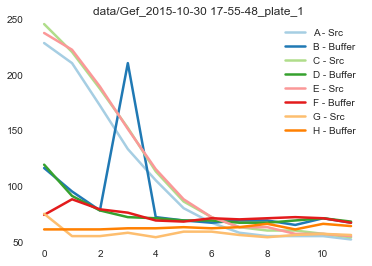

In [15]:
#Just going to work with topread for now
TopRead = root.xpath("/*/Section")[0]
welllist = get_wells_from_section(TopRead)
Gef_dataframe = pd.DataFrame(welllist, columns = ['A - Src','B - Buffer','C - Src','D - Buffer', 'E - Src','F - Buffer','G - Src','H - Buffer'])
Gef_dataframe.plot(figsize=(6, 4), title=file_name)
plt.xlim(-0.5,11.5)

In [16]:
file_GEF_IMA= "data/GefIma_2015-10-30 17-51-13_plate_1.xml"
file_name = os.path.splitext(file_GEF_IMA)[0]
root = etree.parse(file_GEF_IMA)
Sections = root.xpath("/*/Section")
much = len(Sections)
print "****The xml file " + file_GEF_IMA + " has %s data sections:****" % much
for sect in Sections:
    print sect.attrib['Name']

****The xml file data/GefIma_2015-10-30 17-51-13_plate_1.xml has 7 data sections:****
280_TopRead
280_BottomRead
Abs_280
350_TopRead
350_BottomRead
Abs_350
Abs_480


(-0.5, 11.5)

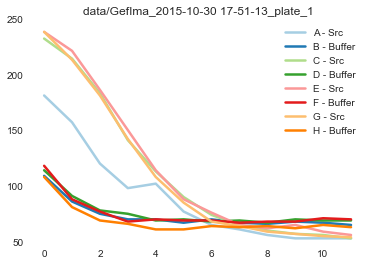

In [17]:
#Just going to work with topread for now
TopRead = root.xpath("/*/Section")[0]
welllist = get_wells_from_section(TopRead)
GefIma_dataframe = pd.DataFrame(welllist, columns = ['A - Src','B - Buffer','C - Src','D - Buffer', 'E - Src','F - Buffer','G - Src','H - Buffer'])
sns.set_palette("Paired", 10)
sns.set_context("notebook", rc={"lines.linewidth": 2.5})

GefIma_dataframe.plot(figsize=(6, 4), title=file_name)
plt.xlim(-0.5,11.5)

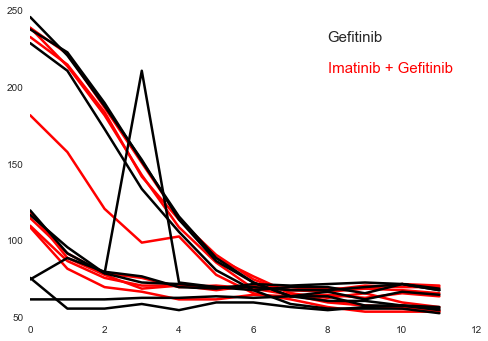

In [18]:
plt.plot(GefIma_dataframe[:].values, 'r');
plt.plot(Gef_dataframe[:].values, 'k');
plt.text(8,230,'Gefitinib',fontsize=15)
plt.text(8,210,'Imatinib + Gefitinib',fontsize=15,color='red')

## Modeled Data

So now let's look at what our expected data might look like. Here we are looking at inhibitor affinities for Src. 
Some initial placeholder data from here again:
http://www.guidetopharmacology.org/GRAC/LigandScreenDisplayForward?ligandId=5710&screenId=2

In [19]:
Kd_Bos = 1.0e-9 # M
Kd_Gef = 3800e-9 # M
Kd_Ima = 3000e-9 # M

From our assay setup we know the Src concentration is 0.5 $\mu$M.

In [20]:
Ptot = 0.5e-6 # M
Ltot = 20.0e-6 / np.array([10**(float(i)/2.0) for i in range(12)]) # M

First let's just plot our two component binding for Bosutinib and Gefitinib.

In [21]:
# Now we can use this to define a function that gives us PL from Kd, Ptot, and Ltot.
def two_component_binding(Kd, Ptot, Ltot):
    """
    Parameters
    ----------
    Kd : float
        Dissociation constant
    Ptot : float
        Total protein concentration
    Ltot : float
        Total ligand concentration
        
    Returns
    -------
    P : float
        Free protein concentration
    L : float
        Free ligand concentration
    PL : float
        Complex concentration
    """
                                    
    PL = 0.5 * ((Ptot + Ltot + Kd) - np.sqrt((Ptot + Ltot + Kd)**2 - 4*Ptot*Ltot))  # complex concentration (uM)
    P = Ptot - PL; # free protein concentration in sample cell after n injections (uM)                                                                                                                                                                                                                          
    L = Ltot - PL; # free ligand concentration in sample cell after n injections (uM)                                                                                                                                                                                                                           
    return [P, L, PL]


In [22]:
[Lb, Pb, PLb] = two_component_binding(Kd_Bos, Ptot, Ltot)
[Lg, Pg, PLg] = two_component_binding(Kd_Gef, Ptot, Ltot)

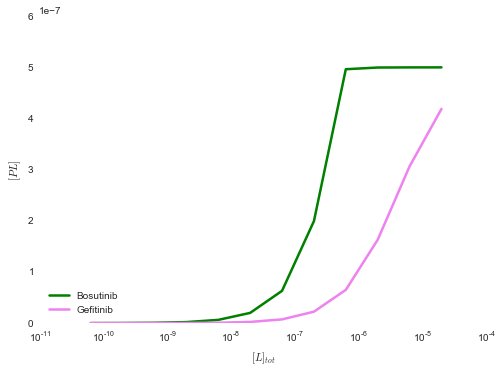

In [23]:
# y will be complex concentration
# x will be total ligand concentration
Bos, = plt.semilogx(Ltot,PLb,'green', label='Bosutinib')
Gef, = plt.semilogx(Ltot,PLg,'violet', label = 'Gefitinib')
plt.xlabel('$[L]_{tot}$')
plt.ylabel('$[PL]$')
plt.ylim(0,6e-7)
plt.legend(loc=3);

Now let's see how we would expect Imatinib to effect this.

From our assay setup we know the Imatinib concentration is

In [24]:
Lima =  10e-6 # M

In [25]:
#Competitive binding function
def three_component_competitive_binding(Ptot, Ltot, Kd_L, Atot, Kd_A):
    """
    Parameters
    ----------
    Ptot : float
        Total protein concentration
    Ltot : float
        Total tracer(fluorescent) ligand concentration
    Kd_L : float
        Dissociation constant
    Atot : float
        Total competitive ligand concentration
    Kd_A : float
        Dissociation constant
        
    Returns
    -------
    P : float
        Free protein concentration
    L : float
        Free ligand concentration
    A : float
        Free ligand concentration
    PL : float
        Complex concentration
    Kd_L_app : float
        Apparent dissociation constant of L in the presence of A
        
    Usage
    -----
    [P, L, A, PL, Kd_L_app] = three_component_competitive_binding(Ptot, Ltot, Kd_L, Atot, Kd_A)
    """
    Kd_L_app = Kd_L*(1+Atot/Kd_A)                                
    PL = 0.5 * ((Ptot + Ltot + Kd_L_app) - np.sqrt((Ptot + Ltot + Kd_L_app)**2 - 4*Ptot*Ltot))  # complex concentration (uM)
    P = Ptot - PL; # free protein concentration in sample cell after n injections (uM)                                                                                                                                                                                                                          
    L = Ltot - PL; # free tracer ligand concentration in sample cell after n injections (uM)
    A = Atot - PL; # free competitive ligand concentration in sample cell after n injections (uM)
    return [P, L, A, PL, Kd_L_app]

In [26]:
[Pbi, Lbi, Abi, PLbi, Kd_bima] = three_component_competitive_binding(Ptot, Ltot, Kd_Bos, Lima, Kd_Ima)
[Pgi, Lgi, Agi, PLgi, Kd_gima] = three_component_competitive_binding(Ptot, Ltot, Kd_Gef, Lima, Kd_Ima)

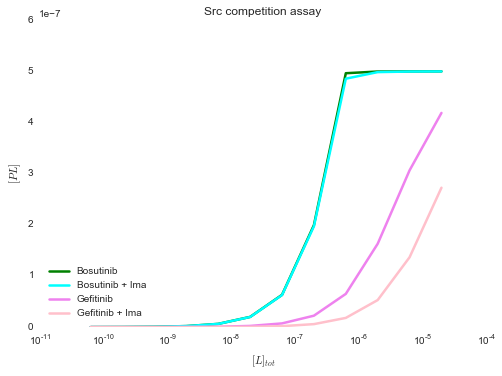

In [27]:
# y will be complex concentration
# x will be total ligand concentration
plt.title('Src competition assay')
Bos, = plt.semilogx(Ltot,PLb,'green', label='Bosutinib')
Bos_Ima, = plt.semilogx(Ltot,PLbi,'cyan', label='Bosutinib + Ima')
Gef, = plt.semilogx(Ltot,PLg,'violet', label = 'Gefitinib')
Gef_Ima, = plt.semilogx(Ltot,PLgi,'pink', label = 'Gefitinib + Ima')
plt.xlabel('$[L]_{tot}$')
plt.ylabel('$[PL]$')
plt.ylim(0,6e-7)
plt.legend(loc=3);

HMMM.

So I was right to think that Gefitinib should work despite the fact that Bosutinib didn't, but...

###Now let's try modeling new experiments with Abl before we actually do them!

In [28]:
#Using expected Kd's from same website as above
Kd_Bos_Abl = 0.1e-9 # M
Kd_Gef_Abl = 480e-9 # M
Kd_Ima_Abl = 21.0e-9 # M

In [29]:
[Lb_Abl, Pb_Abl, PLb_Abl] = two_component_binding(Kd_Bos_Abl, Ptot, Ltot)
[Lg_Abl, Pg_Abl, PLg_Abl] = two_component_binding(Kd_Gef_Abl, Ptot, Ltot)

In [30]:
[Pbi_Abl, Lbi_Abl, Abi_Abl, PLbi_Abl, Kd_bima_Abl] = three_component_competitive_binding(Ptot, Ltot, Kd_Bos_Abl, Lima, Kd_Ima_Abl)
[Pgi_Abl, Lgi_Abl, Agi_Abl, PLgi_Abl, Kd_gima_Abl] = three_component_competitive_binding(Ptot, Ltot, Kd_Gef_Abl, Lima, Kd_Ima_Abl)

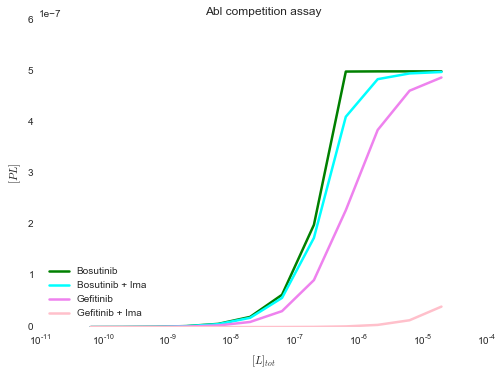

In [31]:
# y will be complex concentration
# x will be total ligand concentration
Bos, = plt.semilogx(Ltot,PLb_Abl,'green', label='Bosutinib')
Bos_Ima, = plt.semilogx(Ltot,PLbi_Abl,'cyan', label='Bosutinib + Ima')
Gef, = plt.semilogx(Ltot,PLg_Abl,'violet', label = 'Gefitinib')
Gef_Ima, = plt.semilogx(Ltot,PLgi_Abl,'pink', label = 'Gefitinib + Ima')
plt.title('Abl competition assay')
plt.xlabel('$[L]_{tot}$')
plt.ylabel('$[PL]$')
plt.ylim(0,6e-7)
plt.legend(loc=3);

Looks promising!

###Let's check out our new data set based on this.

In [76]:
def get_wells_from_section(path):
    reads = path.xpath("*/Well")
    wellIDs = [read.attrib['Pos'] for read in reads]

    data = [(s.text, r.attrib['Pos'])
         for r in reads
         for s in r]

    datalist = {
      well : value
      for (value, well) in data
    }
    
    welllist = [
                [
                 datalist[chr(64 + row) + str(col)]          
                 if chr(64 + row) + str(col) in datalist else None
                 for row in range(1,9)
                ]
                for col in range(1,13)
                ]
                
    return welllist

In [86]:
file_ABL_GEF= "data/Abl_Gef_20160115_170134.xml"
file_name = os.path.splitext(file_ABL_GEF)[0]
root = etree.parse(file_ABL_GEF)
Sections = root.xpath("/*/Section")
much = len(Sections)
print "****The xml file " + file_ABL_GEF + " has %s data sections:****" % much
for sect in Sections:
    print sect.attrib['Name']

****The xml file data/Abl_Gef_20160115_170134.xml has 7 data sections:****
280_TopRead
280_BottomRead
Abs_280
350_TopRead
350_BottomRead
Abs_350
Abs_480


In [87]:
#Just going to work with topread for now
TopRead = root.xpath("/*/Section")[0]
welllist = get_wells_from_section(TopRead)
AblGef_dataframe = pd.DataFrame(welllist, columns = ['A - Abl','B - Buffer','C - Abl','D - Buffer', 'E - Abl','F - Buffer','G - Abl','H - Buffer'])
#AN ERROR FOR 'OVERS' COMES UP UNLESS THE NEXT LINE IS HERE
#THE MAX VALUE IS TAKEN FROM THE MAX VALUE FOR THE ABL GEF IMA DATA
dataframe_rep = AblGef_dataframe.replace({'OVER':'64060.0'})
AblGef_dataframe

,A - Abl,B - Buffer,C - Abl,D - Buffer,E - Abl,F - Buffer,G - Abl,H - Buffer
0,OVER,16344,OVER,15709,OVER,16147,OVER,15312
1,OVER,12553,OVER,12187,OVER,11895,OVER,11148
2,OVER,10356,OVER,10208,OVER,10249,OVER,9579
3,OVER,9525,OVER,9586,OVER,9302,OVER,9120
4,52869,9072,53532,9003,52660,8795,46602,8676
5,34680,8874,32526,8840,32060,8686,29177,8602
6,22075,8904,21329,8792,36716,8819,19811,8738
7,14615,8965,14737,8765,14898,8690,36788,8578
8,11261,8853,11133,9073,12075,8781,11269,8553
9,10495,9006,10780,8945,10782,8751,10182,8512


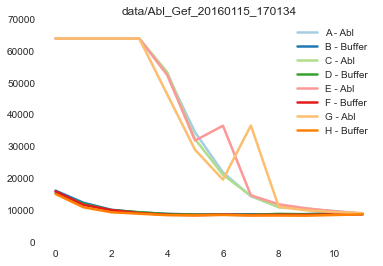

In [88]:
#dataframe_rep[['fluorescence']] = dataframe_rep[['fluorescence']].astype('float')
dataframe_rep = dataframe_rep.astype('float')
sns.set_palette("Paired", 10)
sns.set_context("notebook", rc={"lines.linewidth": 2.5})

dataframe_rep.plot(figsize=(6, 4), title=file_name)
plt.xlim(-0.5,11.5);

In [80]:
file_ABL_GEF_IMA= "data/Abl_GefIma_20160115_165506.xml"
file_name = os.path.splitext(file_ABL_GEF_IMA)[0]
root = etree.parse(file_ABL_GEF_IMA)
Sections = root.xpath("/*/Section")
much = len(Sections)
print "****The xml file " + file_ABL_GEF_IMA + " has %s data sections:****" % much
for sect in Sections:
    print sect.attrib['Name']

****The xml file data/Abl_GefIma_20160115_165506.xml has 7 data sections:****
280_TopRead
280_BottomRead
Abs_280
350_TopRead
350_BottomRead
Abs_350
Abs_480


(-0.5, 11.5)

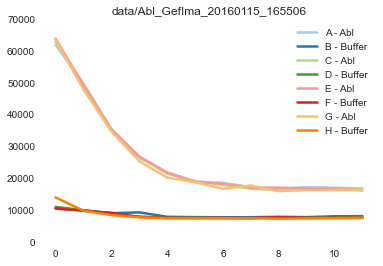

In [81]:
#Just going to work with topread for now
TopRead = root.xpath("/*/Section")[0]
welllist = get_wells_from_section(TopRead)
AblGefIma_dataframe = pd.DataFrame(welllist, columns = ['A - Abl','B - Buffer','C - Abl','D - Buffer', 'E - Abl','F - Buffer','G - Abl','H - Buffer'])
sns.set_palette("Paired", 10)
sns.set_context("notebook", rc={"lines.linewidth": 2.5})
AblGefIma_dataframe = AblGefIma_dataframe.astype('float')

AblGefIma_dataframe.plot(figsize=(6, 4), title=file_name)
plt.xlim(-0.5,11.5)

In [82]:
AblGefIma_dataframe.values.max()

64060.0

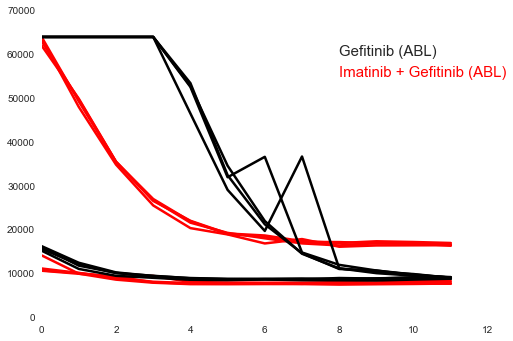

In [85]:
plt.plot(AblGefIma_dataframe[:].values, 'r');
plt.plot(dataframe_rep[:].values, 'k');
plt.text(8,60000,'Gefitinib (ABL)',fontsize=15)
plt.text(8,55000,'Imatinib + Gefitinib (ABL)',fontsize=15,color='red')
plt.savefig('Abl_Gef_Ima_Jan2016.png')

## PYMC for Competition Assay